In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import ishermitian
from itertools import product

np.set_printoptions(linewidth=np.inf, precision=2)

In [3]:
def e_n(n, d):
    # Creates a d-dimensional vector with 1 at the n-th position and 0 elsewhere
    vec = np.zeros(d)
    vec[n%d] = 1
    return vec

def add_conj(mat):
    return mat + mat.conj().T


In [4]:
N_sub = 4 #number of sublattice sites

def H0(phi, N_cells):
    N_tot_sites = N_cells*N_sub
    H0 = np.zeros((N_cells*N_sub, N_cells*N_sub),dtype="complex128")
    for cell_idx in range(N_cells):
        zero_idx = cell_idx*N_sub
        #intracell
        H0[zero_idx, zero_idx + 1] =  np.exp(-1j*phi/2)
        H0[zero_idx, zero_idx + 2] = 1
        H0[zero_idx, zero_idx + 3] = np.exp(1j*phi/2)

        #intercell
        H0[(zero_idx+N_sub)%N_tot_sites, zero_idx + 1] = np.exp(1j*phi/2)
        H0[(zero_idx+N_sub)%N_tot_sites, zero_idx + 2] = 1
        H0[(zero_idx+N_sub)%N_tot_sites, zero_idx + 3] = np.exp(-1j*phi/2)

    return add_conj(H0)

def H(phi, U, N_cells):
    N_tot_sites = N_cells*N_sub
    dim = N_tot_sites**3
    h0 = H0(phi,N_cells)
    H_kin = np.kron(np.kron(h0, np.eye(N_tot_sites)),np.eye(N_tot_sites)) + np.kron(np.kron(np.eye(N_tot_sites),h0),np.eye(N_tot_sites)) + np.kron(np.kron(np.eye(N_tot_sites),np.eye(N_tot_sites)),h0)
    Hint_diag = np.zeros(dim)

    for flat_idx, (i, j, k) in enumerate(product(range(N_tot_sites), repeat=3)):
        occ = np.bincount([i, j, k], minlength=N_tot_sites)
        energy = U / 2 * np.sum(occ * (occ - 1))  # n_i(n_i - 1) for each site
        Hint_diag[flat_idx] = energy

    H_int = np.diag(Hint_diag)
    return H_kin+H_int

def T1(N_sites):
    return np.roll(np.eye(N_sites), shift=N_sub, axis=1)

def rot_sym(N_cells):
    N_tot_sites = N_cells*N_sub
    return np.kron(np.kron(T1(N_tot_sites), T1(N_tot_sites)), T1(N_tot_sites)) 




In [5]:
#### Attempting to generate a fermi penalty term

from itertools import combinations,permutations

def list_antisymmetric_states(N):
    if N < 3:
        raise ValueError("Need at least 3 sites to form antisymmetric 3-particle states.")
    
    return list(combinations(range(N), 3))

def permutation_sign(p):
    """Return the sign (+1 or -1) of a permutation."""
    p = list(p)
    inversions = sum(p[i] > p[j] for i in range(len(p)) for j in range(i+1, len(p)))
    return -1 if inversions % 2 else 1
def antisymmetric_ket(i, j, k, N):
    """Construct the antisymmetric ket for a given (i < j < k) in an N-site system."""
    ket_dict = {}
    for perm in permutations([i, j, k]):
        sign = permutation_sign(perm)
        ket = perm
        ket_dict[ket] = sign
    return ket_dict

def a_state(ket_dict,N):
    state =np.zeros(N**3)
    for ket in ket_dict:
            curr_state = np.kron(np.kron(e_n(ket[0],N),e_n(ket[1],N)),e_n(ket[2],N))
            curr_state = ket_dict[ket]*curr_state
            state += curr_state
    return state

def fermi_penalty(N_cells):
    N_tot_sites = N_cells*N_sub
    dim = N_tot_sites**3
    mat = np.zeros((dim, dim),dtype="complex128")

    assym_list = list_antisymmetric_states(dim)
    for assym_key in assym_list:
        state = a_state(antisymmetric_ket(assym_key[0], assym_key[1],assym_key[2],dim),dim)
        mat += np.kron(state.conj().T, state)
    return mat

In [13]:
import numpy as np
from scipy.sparse import kron, eye, csr_matrix

def swap(N):
    """
    The N^2 × N^2 “swap” (or permutation) operator S acting on H⊗H:
      S |i⟩⊗|j⟩ = |j⟩⊗|i⟩
    """
    rows = []
    cols = []
    data = []
    for i in range(N):
        for j in range(N):
            rows.append(i*N + j)
            cols.append(j*N + i)
            data.append(1)
    return csr_matrix((data, (rows, cols)), shape=(N*N, N*N))

def antisymmetrizer_3(N):
    """
    Build the antisymmetrizer A on (C^N)^{⊗3} as a sparse (N^3×N^3) matrix.
    A = (1/6) ∑_{σ∈S3} sgn(σ) P_σ
      = (1/6)( I - P12 - P13 - P23 + P12 P23 + P23 P12 )
    """
    I_N = eye(N, format='csr')
    I_3 = eye(N**3, format='csr')

    # pairwise swaps
    S = swap(N)         # acts on the first two factors
    P12 = kron(S, I_N)  # swap factors 1↔2
    P23 = kron(I_N, S)  # swap factors 2↔3
    # to get 1↔3 you can do: P13 = P12 @ P23 @ P12
    P13 = P12.dot(P23).dot(P12)

    # build the two 3‑cycles (123) and (132)
    C123 = P12.dot(P23)   # first do 2↔3 then 1↔2
    C132 = P23.dot(P12)

    A = (I_3
         - P12 - P13 - P23
         + C123 + C132) * (1/6)

    return A

# example usage:
N_cells = 4
N_sub = 4
N = N_cells * N_sub
A = antisymmetrizer_3(N)
# if you want H_penalty = V_f * A, just multiply A by your penalty strength.


In [14]:
A

<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 20160 stored elements in Compressed Sparse Row format>

In [6]:
def chain(phi,U,N_cells, gamma1=1,gamma2=1):
    return H(phi,U,N_cells)+ gamma1*rot_sym(N_cells) + gamma2*fermi_penalty(N_cells) 

In [45]:
H(0,1,2)

array([[3.+0.j, 1.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 3.+0.j]])

In [46]:
N_cells = 4
phi=2*np.pi/3
U = 10
gamma2 = 1

chain_mat = H(phi,U,N_cells)+ rot_sym(N_cells) + gamma2*fermi_penalty(N_cells) 

In [18]:
vals, vecs = np.linalg.eig(chain_mat)
mask = np.real(vals) >= -20
filt_vals = vals[mask]
filt_vecs = vecs[:, mask]  # columns are eigenvectors

phases = np.array( [np.round(filt_vecs[:,i].conj().T@rot_sym(N_cells) @ filt_vecs[:,i],decimals=8) for i in range(len(filt_vals))])
energies = np.real(filt_vals - phases)

sorted_angle = np.round(np.sort(np.angle(phases)),decimals=3)
sorted_energies = [energy for _, energy in sorted(zip(np.angle(phases), energies))]

bins = np.count_nonzero(sorted_angle == sorted_angle[0])

Ks, Kidx, K_num = np.unique(sorted_angle, return_index=True, return_counts=True)

K_energy_mesh = np.zeros( (len(Ks), np.max(K_num)))

for idx, kidx in enumerate(Kidx):
    K_energy_mesh[idx] = np.round(np.sort(sorted_energies[kidx:kidx+K_num[idx]]),decimals=3)


Text(0.5, 1.0, 'U = -10, $\\phi = 0$')

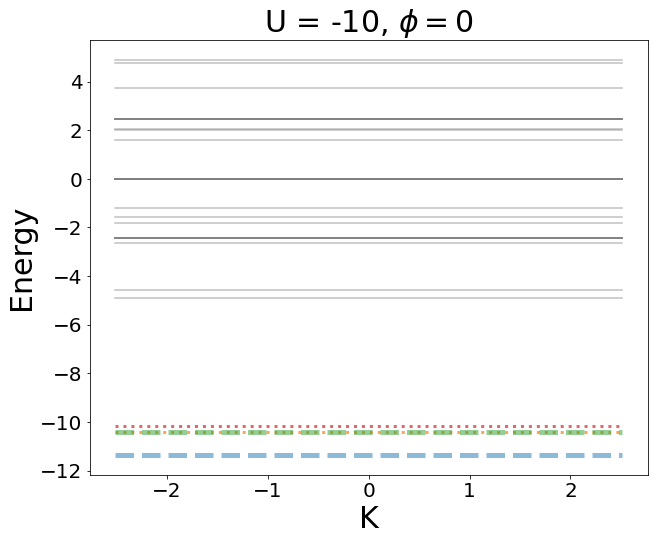

In [39]:
fs = 30

plt.figure(figsize=(10, 8))

for idx, band in enumerate(K_energy_mesh.T):
    if(idx <  4):
        if(idx%2==0):
            plt.plot(Ks,band,lw=5,alpha=.5,linestyle="--")
        else:
            plt.plot(Ks,band,lw=3,alpha=.7,linestyle=":")
    else:
        plt.plot(Ks,band,alpha=.5,color="grey")

plt.xlabel("K",fontsize = fs)
plt.ylabel("Energy",fontsize = fs)
plt.xticks(fontsize=fs-10) 
plt.yticks(fontsize=fs-10)
plt.title(r"U = -10, $\phi = 0$",fontsize=fs)


In [33]:
K_energy_mesh.T[3]

array([-10.17, -10.17, -10.17, -10.17, -10.17])

In [297]:
N_cells = 7
phi=0
U = -10
gamma2 = 1


chain_mat = H(phi,U,N_cells)+ rot_sym(N_cells) + gamma2*fermi_penalty(N_cells) 

In [298]:
vals, vecs = np.linalg.eig(chain_mat)
mask = np.real(vals) >= -20
filt_vals = vals[mask]
filt_vecs = vecs[:, mask]  # columns are eigenvectors

phases = np.array( [np.round(filt_vecs[:,i].conj().T@rot_sym(N_cells) @ filt_vecs[:,i],decimals=8) for i in range(len(filt_vals))])
energies = np.real(filt_vals - phases)

sorted_angle = np.round(np.sort(np.angle(phases)),decimals=3)
sorted_energies = [energy for _, energy in sorted(zip(np.angle(phases), energies))]

bins = np.count_nonzero(sorted_angle == sorted_angle[0])

Ks, Kidx, K_num = np.unique(sorted_angle, return_index=True, return_counts=True)

K_energy_mesh = np.zeros( (len(Ks), np.max(K_num)))

for idx, kidx in enumerate(Kidx):
    K_energy_mesh[idx] = np.round(np.sort(sorted_energies[kidx:kidx+K_num[idx]]),decimals=3)


Text(0.5, 1.0, 'U = 3, $\\phi = 0$')

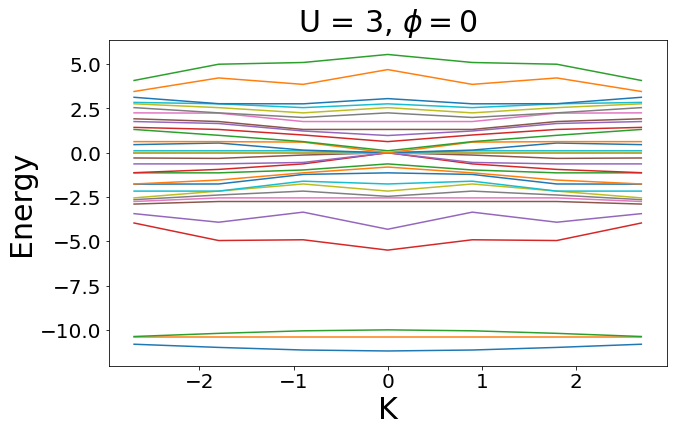

In [299]:
fs = 30

plt.figure(figsize=(10, 6))

for band in K_energy_mesh.T:
    plt.plot(Ks,band)

plt.xlabel("K",fontsize = fs)
plt.ylabel("Energy",fontsize = fs)
plt.xticks(fontsize=fs-10) 
plt.yticks(fontsize=fs-10)
plt.title(r"U = 3, $\phi = 0$",fontsize=fs)


In [34]:
import numpy as np
from itertools import product
from scipy.sparse import csr_matrix, kron, identity, diags
from scipy.sparse.linalg import eigs

# global sublattice size
N_sub = 4

def H0_sparse(phi, N_cells):
    """
    Build the one-body H0 in sparse form.
    """
    N = N_cells * N_sub
    rows, cols, data = [], [], []
    for cell in range(N_cells):
        base = cell * N_sub
        # intracell hoppings
        rows += [base, base, base]
        cols += [base+1, base+2, base+3]
        data += [np.exp(-1j*phi/2), 1, np.exp(1j*phi/2)]
        # intercell hoppings to next cell
        nbr = (base + N_sub) % N
        rows += [nbr, nbr, nbr]
        cols += [base+1, base+2, base+3]
        data += [np.exp(1j*phi/2), 1, np.exp(-1j*phi/2)]
    H = csr_matrix((data, (rows, cols)), shape=(N, N))
    # make Hermitian
    return H + H.conjugate().T


def H_sparse(phi, U, N_cells):
    """
    Build the full 3-particle Hamiltonian (kinetic + interaction) in sparse form.
    """
    N = N_cells * N_sub
    I = identity(N, format='csr')
    h0 = H0_sparse(phi, N_cells)
    # three-body Kron sum
    H_kin = kron(kron(h0, I), I) + kron(kron(I, h0), I) + kron(kron(I, I), h0)

    # on-site interaction diagonal
    dim = N**3
    diag_vals = np.zeros(dim)
    for idx, (i, j, k) in enumerate(product(range(N), repeat=3)):
        occ = np.bincount([i, j, k], minlength=N)
        diag_vals[idx] = U/2 * np.sum(occ * (occ - 1))
    H_int = diags(diag_vals, format='csr')

    return H_kin + H_int


def T1_sparse(N):
    """Sublattice rotation on one tensor factor."""
    I = identity(N, format='csr')
    perm = np.roll(np.arange(N), N_sub)
    return csr_matrix(I[:, perm])


def rot_sym_sparse(N_cells):
    """Three-body rotation symmetry as a sparse operator."""
    N = N_cells * N_sub
    T = T1_sparse(N)
    return kron(kron(T, T), T)


from scipy.sparse.linalg import eigsh
# user parameters
N_cells = 4
phi = 2 * np.pi / 3
U = 30
gamma2 = 1

# build each term
H3 = H_sparse(phi, U, N_cells)
R  = rot_sym_sparse(N_cells)

In [35]:
F  = gamma2 * antisymmetrizer_3(N_cells * N_sub)

In [36]:
# total Hamiltonian
chain_mat = H3 + R + F

In [58]:
# H_sparse is your CSR Hamiltonian of size M=N^3
k =1000    # however many eigenpairs you need
sigma = U       # target the part of spectrum near 0

vals, vecs = eigs(chain_mat, k=k,sigma=sigma,which='LM', tol=1e-5,maxiter=2000)

In [69]:
phases = np.array( [np.round(vecs[:,i].conj().T@R @ vecs[:,i],decimals=8) for i in range(len(vals))])
energies = np.real(vals - phases)

sorted_angle = np.round(np.sort(np.angle(phases)),decimals=3)
sorted_energies = [energy for _, energy in sorted(zip(np.angle(phases), energies))]

bins = np.count_nonzero(sorted_angle == sorted_angle[0])

Ks, Kidx, K_num = np.unique(sorted_angle, return_index=True, return_counts=True)

K_energy_mesh = np.zeros( (len(Ks), np.max(K_num)))

for idx, kidx in enumerate(Kidx):
    K_energy_mesh[idx] = np.round(np.sort(sorted_energies[kidx:kidx+K_num[idx]]),decimals=3)

ValueError: could not broadcast input array from shape (99,) into shape (282,)

In [72]:
# phases ∈ ℂ with |phase|≈1
raw_phases = np.array([
    vecs[:,i].conj().T @ R @ vecs[:,i]
    for i in range(len(vals))
])
raw_angles = np.angle(raw_phases)          # in (–π, π]
energies   = np.real(vals - raw_phases)

# wherever angle ≈ –π, set it to +π
angle_tol = 1e-6
raw_angles[np.isclose(raw_angles, -np.pi, atol=angle_tol)] = np.pi

from collections import defaultdict

k_bins = defaultdict(list)
for k, e in zip(raw_angles, energies):
    k_rounded = np.round(k, decimals=3)
    k_bins[k_rounded].append(e)

# sorted list of unique k‑values
Ks = np.array(sorted(k_bins.keys()))

# find how many bands max over all k
max_bands = max(len(elist) for elist in k_bins.values())

# build mesh of shape (len(Ks), max_bands), fill missing with NaN
K_energy_mesh = np.full((len(Ks), max_bands), np.nan)

for i, k in enumerate(Ks):
    es = np.sort(np.round(k_bins[k], 3))
    K_energy_mesh[i, :len(es)] = es



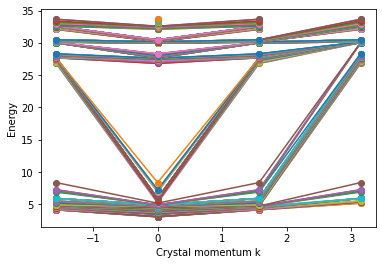

In [73]:
import matplotlib.pyplot as plt

for band_idx in range(K_energy_mesh.shape[1]):
    # mask out the NaNs
    band_energies = K_energy_mesh[:, band_idx]
    valid = ~np.isnan(band_energies)
    plt.plot(Ks[valid], band_energies[valid], '-o')
plt.xlabel("Crystal momentum k")
plt.ylabel("Energy")
plt.show()
